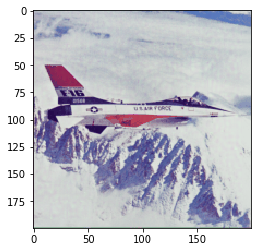

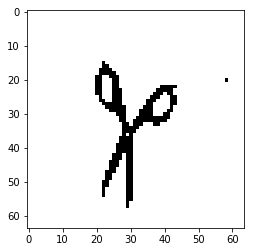

In [246]:
import numpy as np
from scipy.fftpack import dct 
from scipy.fftpack import idct 
from scipy.misc import imread
from skimage.util.shape import view_as_blocks
import matplotlib.pyplot as plot
from math import floor

block_size = 16
k = 32
offset = 10
q = 18

def embed_watermark(watermark, image):
    
    green_channel = np.array(image[:,:,1])
    
    watermark = watermark[:,:,1].flatten()/255
    watermark_position = 0
    
    for block_row in range(green_channel.shape[0] // block_size):
        for block_column in range(green_channel.shape[1] // block_size):
                
            block = green_channel[block_row * block_size : (block_row + 1) * block_size, 
                                  block_column * block_size : (block_column + 1) * block_size]
            dct_coef = dct2(block)    
            zz_coef = zigzag(dct_coef)    
            
            for i in range(k):
                if (watermark_position >= watermark.size): watermark_position = 0
                zz_coef[offset + i] = embed_formula(zz_coef[offset + i], watermark[watermark_position])        
                watermark_position += 1
            
            dct_coef = unzigzag(zz_coef)
            green_channel[block_row * block_size : (block_row + 1) * block_size, 
                          block_column * block_size : (block_column + 1) * block_size] = idct2(dct_coef)
            
    image[:,:,1] = green_channel
    return image

def extract_watermark(image, watermark_shape):
    
    green_channel = np.array(image[:,:,1])
    
    watermark_size = watermark_shape[0] * watermark_shape[1]
    watermark = np.zeros(watermark_size)
    watermark_position = 0
    times_watermark_inserted = 0
    
    for block_row in range(green_channel.shape[0] // block_size):
        for block_column in range(green_channel.shape[1] // block_size):
                
            block = green_channel[block_row * block_size : (block_row + 1) * block_size, 
                                  block_column * block_size : (block_column + 1) * block_size]
            dct_coef = dct2(block)    
            zz_coef = zigzag(dct_coef)
            for i in range(k):
                if watermark_position >= watermark_size: 
                    watermark_position = 0
                    times_watermark_inserted += 1
                    
                watermark[watermark_position] += extract_formula(zz_coef[offset + i])
                watermark_position += 1
            
    watermark = np.array([0 if i < 0.5 else 1 for i in np.round(watermark / times_watermark_inserted)])
    return watermark

zigzag_indices = []
    
for k in range(2*block_size-1):
    for i in range(block_size):
        for j in range(block_size):
            if i+j==k:
                if k%2==0:
                    zigzag_indices += [(i,j)]
                else: 
                    zigzag_indices += [(j,i)]
            
def zigzag(matrix):
    return [matrix[index] for index in zigzag_indices]

def unzigzag(vector):
    matrix = np.zeros((block_size,block_size))
    for i in range(len(zigzag_indices)):
        matrix[zigzag_indices[i]] = vector[i]
    return matrix   

def dct2(image):
    return dct(dct(image.T, norm='ortho').T, norm='ortho')

def idct2(coefficients):
    return idct(idct(coefficients.T, norm='ortho').T, norm='ortho')

def embed_formula(c, w):
    return np.floor(c / q) * q + q / 2 * w * np.sign(c - np.floor(c / q) * q) 

def extract_formula(c):
    return np.round(c / (q / 2)) % 2
    
from PIL import Image
from PIL import ImageEnhance
    
def apply_transformations(image_data):
    
    images = []
    
    image = Image.fromarray(image_data) 
    color = ImageEnhance.Color(image)
    contrast = ImageEnhance.Contrast(image)
    brightness = ImageEnhance.Brightness(image)
    sharpness = ImageEnhance.Sharpness(image)

    for factor in [0, 0.1, 0.3, 1.7, 1.8, 1.9, 2.1, 2.2]:
        images += [color.enhance(factor)] # OK

    for factor in [0.6, 0.7, 1.2, 1.3, 1.4]:
        images += [brightness.enhance(factor)]

    for factor in [0.6, 0.7, 1.2, 1.3, 1.4]:
        images += [contrast.enhance(factor)]
        
    for factor in [-0.5, -0.3, -0.1, 1.7, 1.9, 2.1, 2.2, 2.5]:
        images += [sharpness.enhance(factor)] # OK
        
    #for degree in [90,180,270]:
        #images += [image.rotate(degree)]

    #images += [image.resize((768,768), Image.ANTIALIAS)]
    #images += [image.resize((256,256), Image.ANTIALIAS)]
    #images += [image.resize((128,128), Image.ANTIALIAS)]
    
    return images
    
import os

def generate_dataset(pattern_index, pattern_name, image_name):
    extracted_watermarks = []
    watermark_labels = []
    
    image = embed_watermark(
            imread(pattern_name), 
            imread(image_name))        

    transforms = apply_transformations(image)

    for transform in transforms:
        watermark = extract_watermark(np.asarray(transform), (64,64))

        extracted_watermarks += [watermark]
        watermark_labels += [pattern_index]
    
    return extracted_watermarks, watermark_labels
                
x = []
y = []

for image_name in sorted(os.listdir('images')):
    for pattern_index, pattern_name in enumerate(sorted(os.listdir('patterns'))):
        watermarks, labels = generate_dataset(pattern_index, 'patterns/' + pattern_name, 'images/' + image_name)
        x += watermarks
        y += labels

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

from sklearn.externals import joblib
joblib.dump([x_train, x_test, y_train, y_test], 'real_dataset.pkl')